# Competitor Comparison

This is a sensitivity analysis intended to assess the impact of altering hyperparameters.
Some of the results are summarized in the paper's appendix.
This notebook is an old version of `competitor-comparison-triangular.ipynb`.
It is no longer fuller functional, but these results could be reproduced by modifying the hyperparameters in the current version of `competitor-comparison-triangular.ipynb`.

# Shared Setup

In [1]:
# Generic imports
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from river import linear_model
import copy
from multiprocessing import Pool, cpu_count
import pickle
import tensorflow as tf
import keras
from keras import layers, regularizers

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jzbs0j7o because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-07-31 22:26:47.855691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Imports from this project
from models.models import OracleTS, StandardTS, ActionCenteredTS, RoME, IntelligentPooling, UserLaplacian
from models.river_wrapper import RiverBatchEstimator
from models.bagging_mod import BaggingRegressor
from models.utils import find_neighbors
from simulations.data_generator import DataGenerator

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
# Simulation setup: try some different values
N_STAGES = 200
N_OBSERVATIONS = N_STAGES * (N_STAGES + 1) // 2
N = N_STAGES
T = N_STAGES
THETA = np.array([1., 0.5, -4.])
CONTEXT_DIM = 2
EXTRA_CONTEXT_DIM = 2
LINEAR_BASELINE_COEF = np.array([2., -2., 3.])
THETA_TIME_INIT = np.array([-2., -4., 6.])
P = THETA.size
n_jobs = 25
REPS = 50
N_NEIGHBORS = 5

In [5]:
def get_max_norm(x):
    squared_norms = (x**2).sum(axis=1)
    norms = np.sqrt(squared_norms)
    max_norm = np.max(norms)
    return max_norm

def get_max_norm_for_pairs(x, pairs):
    x_diffs = x[pairs[0]] - x[pairs[1]]
    max_norm = get_max_norm(x_diffs)
    return max_norm

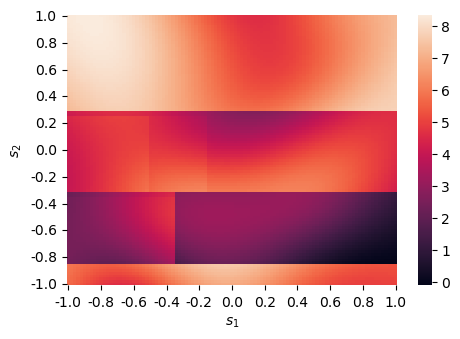

In [6]:
homogeneous_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="homogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
homogeneous_data_generator = homogeneous_data_generator.sample_theta(theta_base=THETA)

heterogeneous_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="heterogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
heterogeneous_data_generator = heterogeneous_data_generator.sample_theta(theta_base=THETA)

nonlinear_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="nonlinear", random_seed=3, nonlinear_scale=1.)  # Seed chosen for its interesting nonlinear relationships
nonlinear_data_generator = nonlinear_data_generator.sample_theta(theta_base=THETA, theta_time_init=THETA_TIME_INIT)

# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)
heatmap_min = np.min(baseline_vals)
heatmap_max = np.max(baseline_vals)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(baseline_vals_df, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/baseline_reward-cov.png")
plt.show()

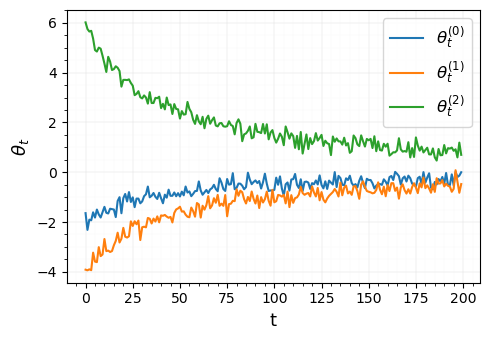

In [7]:
# Time-specifc thetas
fig, ax = plt.subplots(figsize=(5, 3.5))
for i in range(THETA.size):
    label = "$\\theta^{(idx)}_{t}$".replace("idx", str(i))
    ax.plot(nonlinear_data_generator.theta_time[:, i], alpha=1, label=label)
ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
ax.minorticks_on()
ax.set_xlabel("t", fontsize=13)
ax.set_ylabel("$\\theta_{t}$", fontsize=13)
# plt.title("Values of $\\theta_{time}$ Plotted Over Time")
ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig("figures/theta_time-cov.png")
plt.show()

2024-07-31 22:26:52.882770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 1.5210 - val_loss: 1.1071
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0573 - val_loss: 1.0578
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0453 - val_loss: 1.0443
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0364 - val_loss: 1.0552
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0328 - val_loss: 1.0609
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0353 - val_loss: 1.0518
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0319 - val_loss: 1.0469
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0392 - val_loss: 1.0476
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0294 - val_loss: 1.0344
Epoch 10/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0268 - val_loss: 1.0497

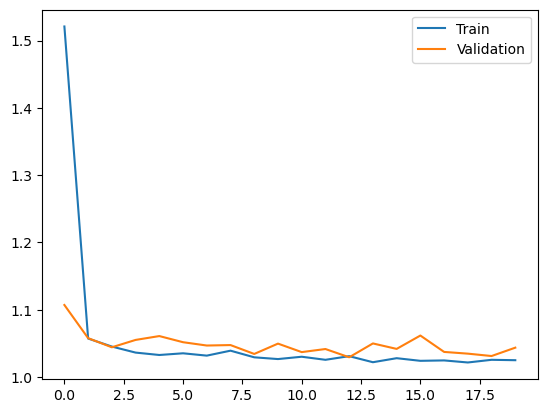

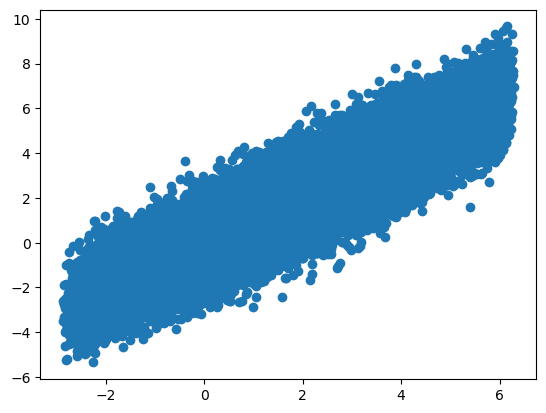

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:26:59           64
config.json                                    2024-07-31 22:26:59         2589
variables.h5                                   2024-07-31 22:26:59        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:26:58           64
config.json                                    2024-07-31 22:26:58         2589
variables.h5                                 

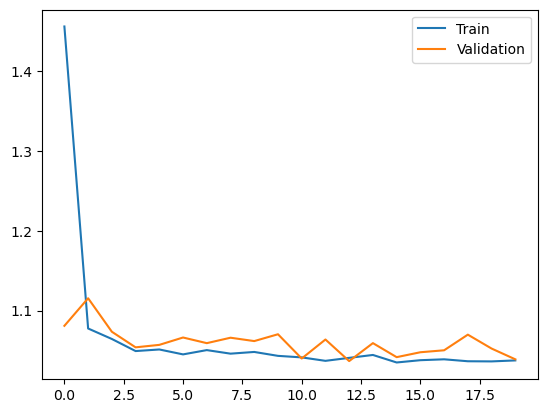

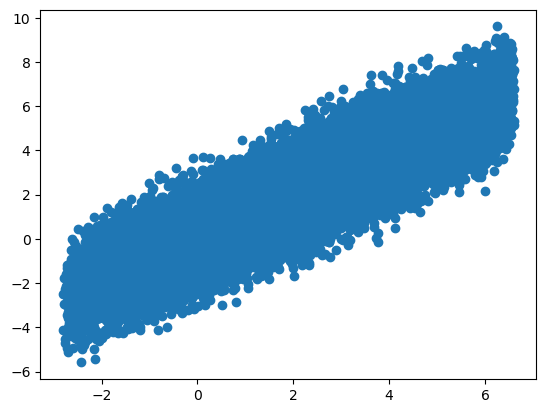

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:05           64
config.json                                    2024-07-31 22:27:05         2591
variables.h5                                   2024-07-31 22:27:05        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:04           64
config.json                                    2024-07-31 22:27:04         2591
variables.h5                                 

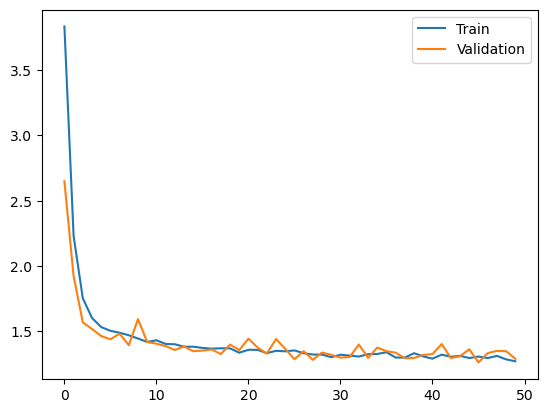

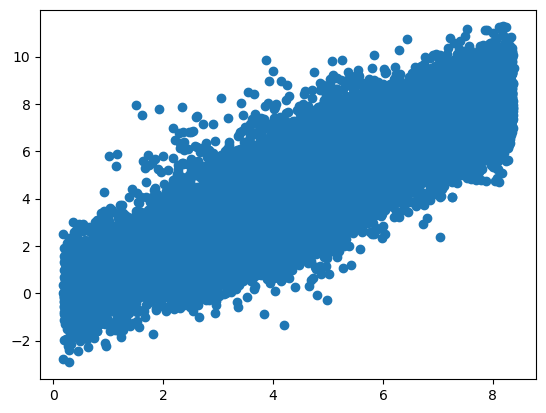

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:20           64
config.json                                    2024-07-31 22:27:20         2591
variables.h5                                   2024-07-31 22:27:20        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:20           64
config.json                                    2024-07-31 22:27:20         2591
variables.h5                                 

In [8]:
%%time
# Neural network stuff
nn_input_dim = CONTEXT_DIM + EXTRA_CONTEXT_DIM

featurizer_nn_models = []
for i, data_generator in enumerate([homogeneous_data_generator, heterogeneous_data_generator, nonlinear_data_generator]):
    # Create data
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_train, y_train = data_generator.generate_baselines_for_nn()
    
    data_generator = data_generator.reset()
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_validation, y_validation = data_generator.generate_baselines_for_nn()
    
    # Train model
    penalty = 0.001
    nn_output_dim = 10
    model = keras.Sequential(
        [
            keras.Input(shape=(nn_input_dim,), name="input"),
            layers.Dense(10, activation="relu", name="layer1", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="relu", name="layer2", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="tanh", name="layer3", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(nn_output_dim, activation="tanh", name="layer4", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(1, name="output", kernel_regularizer=regularizers.l2(penalty)),
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=opt)
    history = model.fit(
        X_train,
        y_train,
        batch_size=200,
        validation_data=(X_validation, y_validation),
        epochs=50 if i == 2 else 20,
        verbose=1
    )
    
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.legend()
    plt.show()

    preds_validation = model(X_validation)
    plt.scatter(preds_validation, y_validation)
    plt.show()
    
    # Featurizer model
    featurizer_nn_model = keras.Model(
        inputs=model.input,
        outputs=model.get_layer("layer4").output)
    
    featurizer_nn_models.append(copy.deepcopy(featurizer_nn_model))

homogeneous_featurizer_nn_model = featurizer_nn_models[0]
heterogeneous_featurizer_nn_model = featurizer_nn_models[1]
nonlinear_featurizer_nn_model = featurizer_nn_models[2]

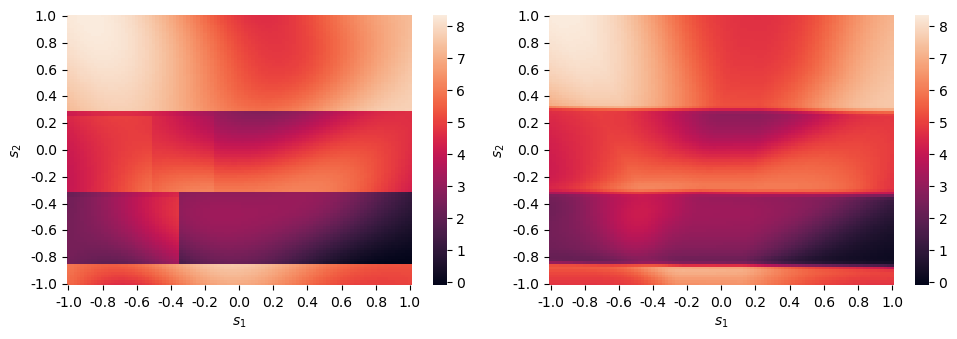

In [9]:
# # Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
sns.heatmap(baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_xlabel("$s_{1}$")
ax[0].set_ylabel("$s_{2}$")

nn_context_values = np.hstack([context_values, np.zeros_like(context_values)])
nn_baseline_vals = model(nn_context_values).numpy()
nn_baseline_vals_df = pd.DataFrame(
    data=nn_baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_xlabel("$s_{1}$")
ax[1].set_ylabel("$s_{2}$")

fig.tight_layout()
fig.savefig("figures/nn_baseline_reward_comparison-cov.png")
plt.show()

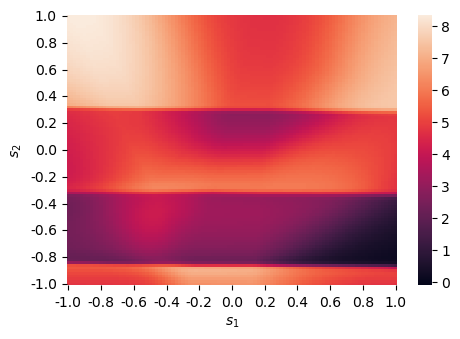

In [10]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/nn_baseline_reward-cov.png")
plt.show()

In [11]:
# This determines the plotting order
non_oracle_method_names = [
    "IntelPooling",
    "RoME-BLM",
    "RoME",
    "RoME-SU",
    "AC",
    "Standard",
    "Neural-Linear",
    "NNR-Linear"
]

def create_reward_dict(data_generator, nn, seed):
    np.random.seed(seed)
    user_pairs, L_user = find_neighbors(data_generator.theta_user, N_NEIGHBORS)
    time_pairs, L_time = find_neighbors(data_generator.theta_time, N_NEIGHBORS)
    
    # Doubling these values to make them more reasonable
    d_user = get_max_norm(data_generator.theta_user) * 2
    d_time = get_max_norm(data_generator.theta_time) * 2
    b_user = get_max_norm_for_pairs(data_generator.theta_user, user_pairs) * 2
    b_time = get_max_norm_for_pairs(data_generator.theta_time, time_pairs) * 2
    bagged_lm = RiverBatchEstimator(
        BaggingRegressor(
            linear_model.LinearRegression(l2=1e-8, intercept_lr=0.1),
            n_models=10,
            subsample=0.8
        )
    )

    # Set covariances
    cov_epsilon = 1e-18
    user_cov = np.cov(data_generator.theta_user.T)
    if user_cov.sum() < cov_epsilon:
        user_cov += cov_epsilon * np.eye(user_cov.shape[0])
    time_cov = np.cov(data_generator.theta_time.T)
    if time_cov.sum() < cov_epsilon:
        time_cov += cov_epsilon * np.eye(time_cov.shape[0])

    nn_numpy = lambda x: nn(x).numpy()
    non_oracle_methods_dict = {
        "IntelPooling": IntelligentPooling(N, T, P, DataGenerator._featurize, user_cov=user_cov, time_cov=time_cov),
        "RoME": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=10*user_cov, time_cov=10*time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS),
        "RoME-BLM": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=10*user_cov, time_cov=10*time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, ml_interactions=True, ml_model=bagged_lm, n_neighbors=N_NEIGHBORS),
        "RoME-SU": RoME(1, T, P, DataGenerator._featurize, L_user, L_time, user_cov=10*user_cov, time_cov=10*time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS, pool_users=False),
        "AC": ActionCenteredTS(N, T, P, DataGenerator._featurize),
        "Standard": StandardTS(N, T, P, DataGenerator._featurize),
        "Neural-Linear": StandardTS(N, T, P, DataGenerator._featurize, nn=nn_numpy, nn_dim=nn_output_dim),
        "NNR-Linear": UserLaplacian(N, T, P, DataGenerator._featurize, L_user, user_cov=user_cov),
    }
    methods_dict = copy.copy(non_oracle_methods_dict)
    methods_dict["Oracle"] = OracleTS(N, T, THETA, data_generator.theta_user, data_generator.theta_time, DataGenerator._featurize)
    
    # Dictionary for storing rewards
    rewards_dict = {k:np.zeros((N, T)) for k in methods_dict}

    # Generate context vectors that we'll use for all models
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)

    # Iterate through methods
    for method_name, method in methods_dict.items():
        rewards = []
        data_generator = data_generator.reset()
        method.reset()

        while not data_generator.finished:
            # Randomly samples action from current policy
            context, context_extra, user_idx, time_idx = data_generator.get_current_context()
            action = method.sample_action(context, user_idx, time_idx)

            # Plays action and returns reward
            reward = data_generator.play_action(action)
            rewards_dict[method_name][user_idx, time_idx] = reward

            # Update method inferences
            method.update(context, context_extra, user_idx, time_idx, action, reward)
                
    return rewards_dict

In [12]:
def run_simulation(data_generator, nn, REPS=REPS, n_jobs=cpu_count()):    
    # Perform whole simulation REPS times
    with Pool(min(REPS, n_jobs)) as p:
        rewards_list_of_dicts = p.starmap(create_reward_dict, zip([data_generator]*REPS, [nn]*REPS, range(REPS)))
        
    rewards_dict = {}
    method_names = list(rewards_list_of_dicts[0].keys())
    non_oracle_method_names = list(set(method_names) - set(["Oracle"]))
    for method_name in method_names:
        rewards_dict[method_name] = np.asarray([
            rewards_list_of_dicts[i][method_name]
            for i in range(REPS)])
                
    return rewards_dict

In [13]:
def get_avg_stage_reward(a):
    means = [a[:, ::-1].diagonal(i, axis1=1, axis2=2).mean(axis=1) for i in range(-a.shape[1]+1,a.shape[2])]
    return np.asarray(means)[:a.shape[1]]


def plot_rewards_dict(rewards_dict, assumptions):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax0 = ax[0]
    ax1 = ax[1]
    
    # Method names
    # non_oracle_method_names = set(rewards_dict.keys()) - {"Oracle",}
    # non_oracle_method_names = sorted(list(non_oracle_method_names))

    # Calculate incremental regret
    oracle_incremental_regret = get_avg_stage_reward(rewards_dict["Oracle"])
    incremental_regret_dict = {
        method_name: (oracle_incremental_regret - get_avg_stage_reward(rewards_dict[method_name])).mean(axis=1)  # Mean over reps
        for method_name in non_oracle_method_names}

    # Calculate cumulative regret
    cumulative_regret_dict = {method_name: np.cumsum(incremental_regret_dict[method_name]) for method_name in non_oracle_method_names}

    # Plot incremental regret
    for method_name in non_oracle_method_names:
        ax0.plot(incremental_regret_dict[method_name], label=method_name, )
    ax0.set_title("(a) Incremental Regret Over Time", pad=10)
    ax0.set_ylabel("Incremental Regret")
    ax0.set_xlabel("Stage")
    ax0.legend()

    # Plot cumulative regret
    for method_name in non_oracle_method_names:
        ax1.plot(cumulative_regret_dict[method_name], label=method_name)
    ax1.set_title("(b) Cumulative Regret Over Time", pad=10)
    ax1.set_ylabel("Cumulative Regret")
    ax1.set_xlabel("Stage")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.savefig(f"figures/{assumptions}-regret-cov.png")
    fig.suptitle(f"Regret for {assumptions.capitalize()} Data-Generating Process")
    plt.show()

# Simulation 1: Homogeneous Users, Linear Baseline, No Time Effects

In [14]:
%%time
homogeneous_rewards_dict = run_simulation(homogeneous_data_generator, homogeneous_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:21           64
config.json                                    2024-07-31 22:27:21         2589
variables.h5                                   2024-07-31 22:27:21        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-07-31 22:27:20           64
config.json                                    2024-07-31 22:27:20         2589
variables.h5                                 

In [15]:
homogeneous_rewards_filename = "checkpoints/homogeneous_rewards-cov.pkl"
with open(homogeneous_rewards_filename, 'wb') as file:
    pickle.dump(homogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open(homogeneous_rewards_filename, "rb") as file:
    homogeneous_rewards_dict = pickle.load(file)

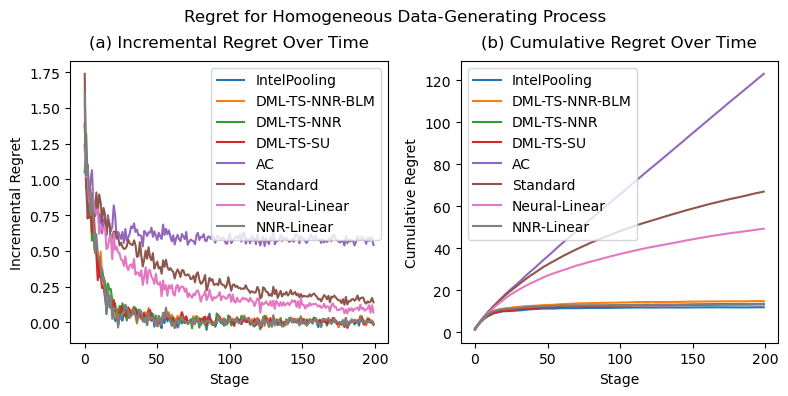

In [17]:
plot_rewards_dict(homogeneous_rewards_dict, "homogeneous")

# Simulation 2: Heterogeneous Users, Linear Baseline, No Time Effects

In [18]:
%%time
heterogeneous_rewards_dict = run_simulation(heterogeneous_data_generator, heterogeneous_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-08-01 00:49:10           64
config.json                                    2024-08-01 00:49:10         2591
variables.h5                                   2024-08-01 00:49:10        19128
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2024-08-01 00:49:10           64
config.json                                    2024-08-01 00:49:10         2591
variables.h5                                 

In [19]:
heterogeneous_rewards_filename = "checkpoints/heterogeneous_rewards-cov.pkl"
with open(heterogeneous_rewards_filename, 'wb') as file:
    pickle.dump(heterogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open(heterogeneous_rewards_filename, "rb") as file:
    heterogeneous_rewards_dict = pickle.load(file)

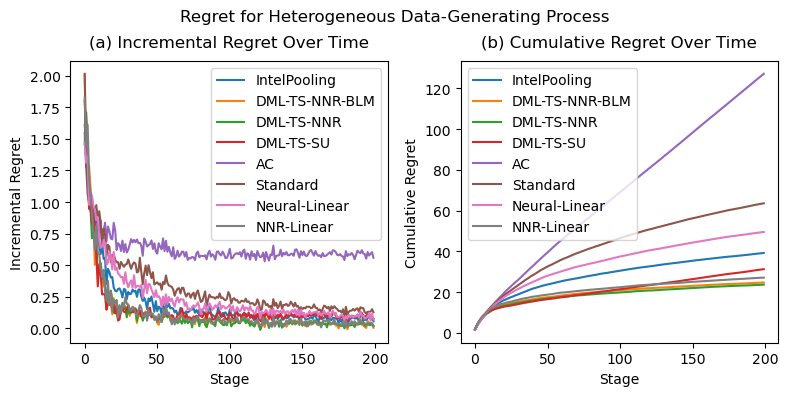

In [21]:
plot_rewards_dict(heterogeneous_rewards_dict, "heterogeneous")

# Simulation 3: Nonlinear Baseline and User-/Time-specific Effects

In [22]:
%%time
nonlinear_rewards_dict = run_simulation(nonlinear_data_generator, nonlinear_featurizer_nn_model, n_jobs=n_jobs)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2024-08-01 04:25:23           64
config.json                                    2024-08-01 04:25:23         2591
variables.h5                                   2024-08-01 04:25:23        19128
Keras model archive loading:
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
.

In [23]:
nonlinear_rewards_filename = "checkpoints/nonlinear_rewards-cov.pkl"
with open(nonlinear_rewards_filename, 'wb') as file:
    pickle.dump(nonlinear_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open(nonlinear_rewards_filename, "rb") as file:
    nonlinear_rewards_dict = pickle.load(file)

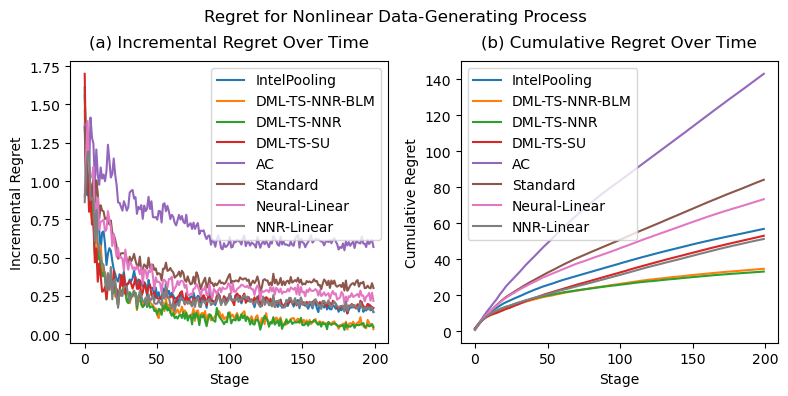

In [25]:
plot_rewards_dict(nonlinear_rewards_dict, "nonlinear")

# Cumulative Regret for All Three Settings

## Calculations

In [26]:
# Calculate incremental regret
incremental_homogeneous_regret_dict = {
    method_name: get_avg_stage_reward(homogeneous_rewards_dict["Oracle"]) - get_avg_stage_reward(homogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_heterogeneous_regret_dict = {
    method_name: get_avg_stage_reward(heterogeneous_rewards_dict["Oracle"]) - get_avg_stage_reward(heterogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_nonlinear_regret_dict = {
    method_name: get_avg_stage_reward(nonlinear_rewards_dict["Oracle"]) - get_avg_stage_reward(nonlinear_rewards_dict[method_name])
    for method_name in non_oracle_method_names}

# Calculate cumulative regret
cumulative_homogeneous_regret_dict = {method_name: np.cumsum(incremental_homogeneous_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}
cumulative_heterogeneous_regret_dict = {method_name: np.cumsum(incremental_heterogeneous_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}
cumulative_nonlinear_regret_dict = {method_name: np.cumsum(incremental_nonlinear_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}

# Final regret
final_homogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_homogeneous_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_homogeneous_regret_df.to_csv("./checkpoints/final_homogeneous_regret-cov.csv", index=False)

final_heterogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_heterogeneous_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_heterogeneous_regret_df.to_csv("./checkpoints/final_heterogeneous_regret-cov.csv", index=False)

final_nonlinear_regret_df = pd.DataFrame({
    method_name: cumulative_nonlinear_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_nonlinear_regret_df.to_csv("./checkpoints/final_nonlinear_regret-cov.csv", index=False)

## Plots

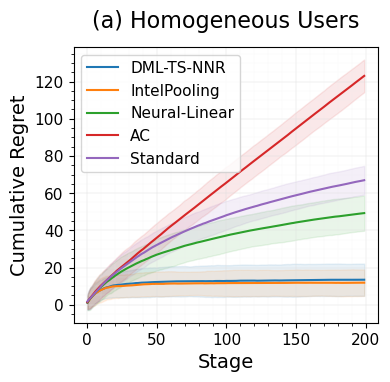

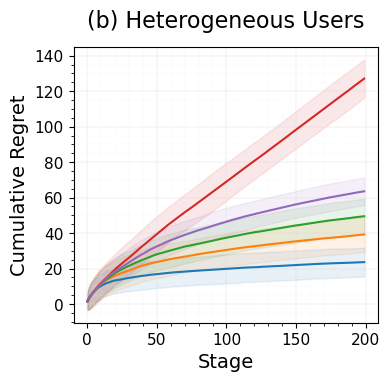

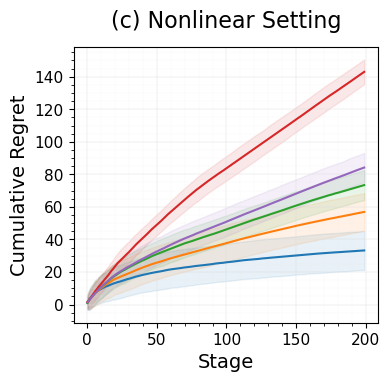

In [27]:
def plot_cumulative_regret(cumulative_regret_dict, setting_name, include_legend=False, loc="main", include_bands=True):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    for i, method_name in enumerate(cumulative_regret_dict.keys()):
        color_i = f"C{i}"
        method_means = cumulative_regret_dict[method_name].mean(axis=1)
        method_range = np.arange(method_means.size)
        method_sds = cumulative_regret_dict[method_name].std(axis=1)
        method_lower = method_means - 1.96 * method_sds
        method_upper = method_means + 1.96 * method_sds
        if include_bands:
            ax.fill_between(method_range, method_lower, method_upper, color=color_i, alpha=0.1)
        ax.plot(method_range, method_means, label=method_name, color=color_i)
        
    ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
    ax.minorticks_on()
    ax.set_title(setting_name, pad=14, fontsize=16)
    ax.set_ylabel("Cumulative Regret", fontsize=14)
    ax.set_xlabel("Stage", fontsize=14)
    ax.tick_params(axis='both', labelsize=11)
    if include_legend:
        ax.legend(fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    setting_name_for_file = setting_name.replace("(", "").replace(")", "").replace(" ", "-")
    fig.savefig(f"figures/cumulative-regret-{setting_name_for_file}-{loc}-cov.png")
    # fig.suptitle("Comparison of Cumulative Regret by Method")
    plt.show()

main_paper_methods = ["RoME", "IntelPooling", "Neural-Linear", "AC", "Standard"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(a) Homogeneous Users", include_legend=True)

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False)

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in main_paper_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False)

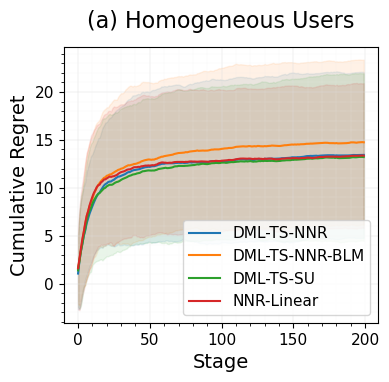

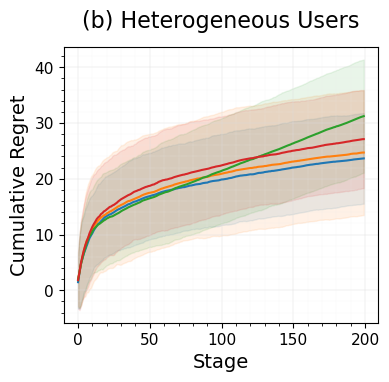

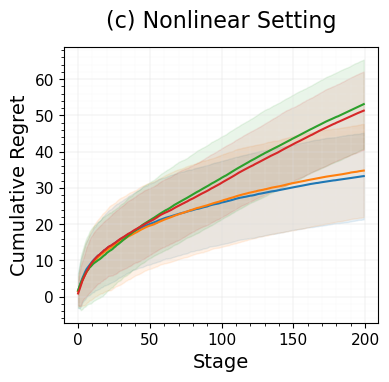

In [28]:
appendix_methods = ["RoME", "RoME-BLM", "RoME-SU", "NNR-Linear"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(a) Homogeneous Users", include_legend=True, loc="app")

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False, loc="app")

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in appendix_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False, loc="app")

## Comparison Tables

### Extra

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
final_homogeneous_regret_df = pd.read_csv("./checkpoints/final_homogeneous_regret-cov.csv")
final_heterogeneous_regret_df = pd.read_csv("./checkpoints/final_heterogeneous_regret-cov.csv")
final_nonlinear_regret_df = pd.read_csv("./checkpoints/final_nonlinear_regret-cov.csv")

In [31]:
non_oracle_method_names_sorted = [
    'RoME',
    'RoME-BLM',
    'RoME-SU',
    'NNR-Linear',
    'IntelPooling',
    'Neural-Linear',
    'Standard',
    'AC',
]

In [32]:
def create_comparison_df(final_regret_df):
    comparison_outer_list = []
    win_percentages = []
    for method_row in non_oracle_method_names_sorted:
        comparison_inner_list = []
        win_percentage = 0.
        for method_column in non_oracle_method_names_sorted:
            diffs = final_regret_df[method_column] - final_regret_df[method_row]
            percent_row_better = np.mean(diffs > 0)
            avg_diff = np.mean(diffs)
            p_value = ttest_1samp(diffs, popmean=0).pvalue
            if method_row == method_column:
                cell_text = "-"
            else:
                win_percentage += percent_row_better / (len(non_oracle_method_names_sorted) - 1)
                cell_text = f"{percent_row_better:.0%}{'*' if p_value < 0.05 else ''}"
            comparison_inner_list.append(cell_text)
        comparison_outer_list.append(comparison_inner_list)
        win_percentages.append(f"{win_percentage:.0%}")
    comparison_df = pd.DataFrame(
        comparison_outer_list,
        index=[f"{i+1}. {n}" for i, n in enumerate(non_oracle_method_names_sorted)],
        columns=range(1, len(non_oracle_method_names_sorted)+1))
    comparison_df["\textbf{Avg}"] = win_percentages
    latex_table = comparison_df.to_latex(escape=False).replace("%", "\%")
    print(latex_table)
    return comparison_df

In [33]:
homogeneous_comparison_df = create_comparison_df(final_homogeneous_regret_df)
homogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 58\% & 50\% & 52\% & 30\%* & 100\%* & 100\%* & 100\%* & 70\% \\
2. RoME-BLM & 42\% & - & 40\%* & 38\%* & 24\%* & 100\%* & 100\%* & 100\%* & 63\% \\
3. RoME-SU & 50\% & 60\%* & - & 44\% & 34\%* & 100\%* & 100\%* & 100\%* & 70\% \\
4. NNR-Linear & 48\% & 62\%* & 56\% & - & 32\%* & 100\%* & 100\%* & 100\%* & 71\% \\
5. IntelPooling & 70\%* & 76\%* & 66\%* & 68\%* & - & 100\%* & 100\%* & 100\%* & 83\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 98\%* & 100\%* & 28\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 15\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,58%,50%,52%,30%*,100%*,100%*,100%*,70%
2. RoME-BLM,42%,-,40%*,38%*,24%*,100%*,100%*,100%*,63%
3. RoME-SU,50%,60%*,-,44%,34%*,100%*,100%*,100%*,70%
4. NNR-Linear,48%,62%*,56%,-,32%*,100%*,100%*,100%*,71%
5. IntelPooling,70%*,76%*,66%*,68%*,-,100%*,100%*,100%*,83%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,98%*,100%*,28%
7. Standard,0%*,0%*,0%*,0%*,0%*,2%*,-,100%*,15%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [34]:
heterogeneous_comparison_df = create_comparison_df(final_heterogeneous_regret_df)
heterogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 46\% & 88\%* & 68\%* & 100\%* & 100\%* & 100\%* & 100\%* & 86\% \\
2. RoME-BLM & 54\% & - & 84\%* & 68\%* & 100\%* & 100\%* & 100\%* & 100\%* & 87\% \\
3. RoME-SU & 12\%* & 16\%* & - & 18\%* & 92\%* & 100\%* & 100\%* & 100\%* & 63\% \\
4. NNR-Linear & 32\%* & 32\%* & 82\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 78\% \\
5. IntelPooling & 0\%* & 0\%* & 8\%* & 0\%* & - & 96\%* & 100\%* & 100\%* & 43\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 4\%* & - & 98\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 15\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,46%,88%*,68%*,100%*,100%*,100%*,100%*,86%
2. RoME-BLM,54%,-,84%*,68%*,100%*,100%*,100%*,100%*,87%
3. RoME-SU,12%*,16%*,-,18%*,92%*,100%*,100%*,100%*,63%
4. NNR-Linear,32%*,32%*,82%*,-,100%*,100%*,100%*,100%*,78%
5. IntelPooling,0%*,0%*,8%*,0%*,-,96%*,100%*,100%*,43%
6. Neural-Linear,0%*,0%*,0%*,0%*,4%*,-,98%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,2%*,-,100%*,15%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


### Nonlinear Setting

In [35]:
nonlinear_comparison_df = create_comparison_df(final_nonlinear_regret_df)
nonlinear_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 54\% & 98\%* & 98\%* & 100\%* & 100\%* & 100\%* & 100\%* & 93\% \\
2. RoME-BLM & 46\% & - & 98\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 92\% \\
3. RoME-SU & 2\%* & 2\%* & - & 36\% & 76\%* & 100\%* & 100\%* & 100\%* & 59\% \\
4. NNR-Linear & 2\%* & 0\%* & 64\% & - & 82\%* & 100\%* & 100\%* & 100\%* & 64\% \\
5. IntelPooling & 0\%* & 0\%* & 24\%* & 18\%* & - & 100\%* & 100\%* & 100\%* & 49\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 98\%* & 100\%* & 28\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 15\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,54%,98%*,98%*,100%*,100%*,100%*,100%*,93%
2. RoME-BLM,46%,-,98%*,100%*,100%*,100%*,100%*,100%*,92%
3. RoME-SU,2%*,2%*,-,36%,76%*,100%*,100%*,100%*,59%
4. NNR-Linear,2%*,0%*,64%,-,82%*,100%*,100%*,100%*,64%
5. IntelPooling,0%*,0%*,24%*,18%*,-,100%*,100%*,100%*,49%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,98%*,100%*,28%
7. Standard,0%*,0%*,0%*,0%*,0%*,2%*,-,100%*,15%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [36]:
final_nonlinear_regret_df

,IntelPooling,RoME-BLM,RoME,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear
0,55.576990,36.257054,29.444703,47.429288,138.513413,84.164855,71.734912,50.465717
1,48.923903,23.591179,26.605805,51.805962,140.556270,69.450685,77.717645,50.160768
2,56.722796,33.904014,27.695139,54.874926,141.801915,75.972919,68.416537,46.095840
3,46.745882,27.742576,29.341336,50.864794,149.383349,86.952215,71.719263,42.921491
4,50.538686,34.203820,37.118206,45.968406,142.731606,79.730129,63.765453,46.876672
5,61.729105,25.473445,38.693338,45.755559,145.028294,83.884281,75.367194,46.822268
6,50.860804,33.148421,43.012411,47.171733,139.644067,86.083170,79.033951,54.588442
7,50.807392,40.550626,47.784617,43.727444,139.019617,81.792206,72.359170,41.255705
8,56.341955,26.000997,37.295812,42.868264,136.521394,86.701797,61.638706,42.156404
9,61.939008,41.212028,25.507139,54.090644,140.829186,87.312895,71.301664,54.800396


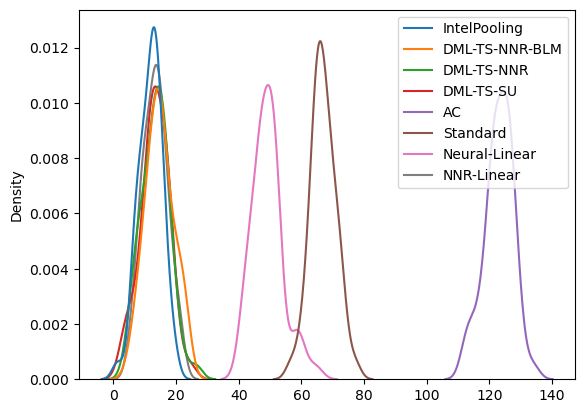

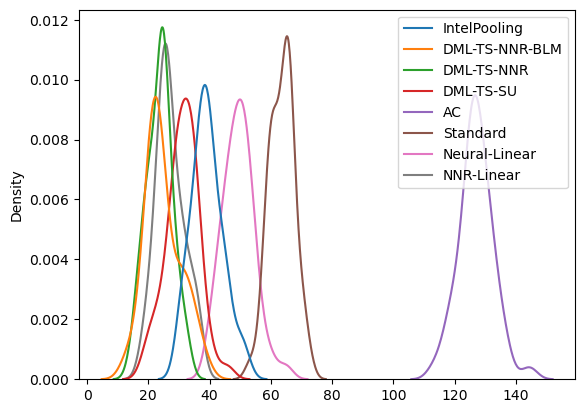

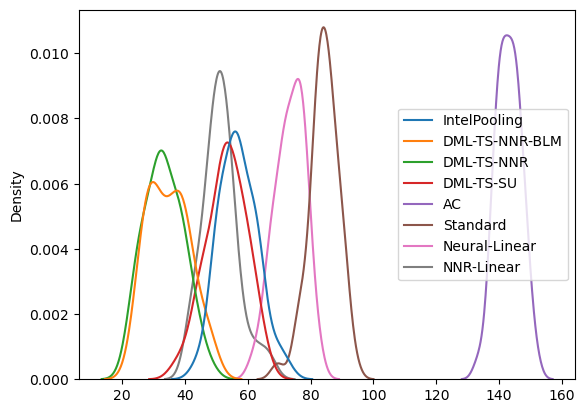

In [37]:
sns.kdeplot(data=final_homogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_heterogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_nonlinear_regret_df)
plt.show()